# Multi-agent DDPG applied to Tennis game

---
This project is a part of the Udacity Deep Reinforcement Learning Nano-degree requirement. In this report, I described how I used the Multi-Agent Actor-Critic algorithm [here](https://arxiv.org/pdf/1706.02275v4.pdf) to solve the Tennis game provided by Unity Environment [here](https://github.com/Unity-Technologies/ml-agents/tree/release_12_docs). 

### The Environment

<img src='Tennis.gif' width="400" height="250">

The game environment is provided by Unit Technology (please refer to README on how to install). There are two agents controling rackets to bounce a ball across the net. A reward of `+0.1` is earned each time an aent hits the ball over the net within the court boundary. If the ball hits the ground or it is out of the boundary of the court, the agent receices `-0.01`. The environment is considered solved when the max cumulative return of the agents reaches an average of `+0.5` over 100 episodes. 

The environment is considered cooperative because the agents need to learn how to bounce the ball in a way the the other agent can bounce back easily to keep the game going and therefore earning higher returns.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import itertools
from collections import namedtuple, deque
from MADDPG import MADDPG
from Buffer import buffer
from unityagents import UnityEnvironment

In [2]:
# define named tuple to organize the memory operation
Transition = namedtuple('Transition', ('state_full','state', 'action_full', 'action', 'reward', 'state_next_full', 'state_next', 'done'))

In [3]:
# import environment - see README on installation
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


The observation space consists of `24` continuous variables corresponding to the ball position, agent position, speed etc. collected for three consecutive time framework. The actions are a vector with two continuous variables between `-1` and `1`, corresponding to forward/backward and jump. 

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


### MADDPG (Multi-agent DDPG)

[MADDPG](https://arxiv.org/pdf/1706.02275v4.pdf) was introduced to solve both cooperative and competitive environment involving more than one agent under a continuous action space. The difference between MADDPG and a plain vanilla DDPG is that the agents are trained using global observation of the environment state and joint actions of the agents centrally but the agents' policies are evaluated using their private observations and own actions. Multi-agent environment is in general challenging because the environment changes (non-stationary) as the agents' policies evolve and therefore needs careful hyper-parameter tuning.

The hyper-parameters are set as following:  
1. A neural network with `2` hidden layers with an input dimension of `26` (24 + 2) for the actor and `52` (24*2 + 2*2) for the critic; the first hidden layer has a dimension of `64` for the actor and `128` for the critic; the second hidden layer has a dimension of `32` for the actor and `64` for the critic; the output layer dimension is `2` for the actor and `1` for the critic. A ReLU activation function is applied for all layers except the output layer, where a Tanh function is applied to the actor and no activation function for the critic. Each agent has its own actor and critic network function with the same structure. 
2. The optimizer is set to Adam optimizer with a learning rate of `0.0025` for both the actor and critic 
3. TAU, the rate at which the target network is synchronized to the policy network every time step is set to `0.05`
4. The memory is set to `100,000` entries, containing the private state, action and reward for each agent, as well as the global state (a concatenation of the private state of the agents).
5. The batch size is set to `1024` used in each time step, with a maximum training of 50 times in one episode of play
6. The policy noise is set to `2.0` at the beginning, which decays every time step by a factor of `0.9999`. The minimum policy noise is set to `0.4` to keep the agents exploring because the environment is likely to change as the agents' polices evolve.
7. The discount factor is set to `0.99`. 
8. Finally, the number of episode is set to `1500`, which includes `200` episode of random exploring with no policy noise decay.

In [5]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

maddpg_agents = MADDPG(num_agents, state_size*num_agents, action_size*num_agents, state_size, action_size, device)
buffer = buffer(num_agents, device)

In [6]:
def train(maddpg_agents, n_episodes=1500, n_episodes_wait=200, update_every=1, \
          batch_size=1024, noise_start=2., noise_decay=0.9999, noise_end=0.4, share_experience=False):

    noise = noise_start
    scores = []
    scores_window = deque(maxlen=100)
    best_score = -np.inf

    for i_episode in range(1, n_episodes+1):
        step = 0
        score = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        dones = env_info.local_done

        while not np.any(dones):
            
            transitions = []

            if i_episode <= n_episodes_wait:
                noise = noise_start
                actions = np.random.randn(num_agents, action_size)  # select an action (for each agent)
                actions = np.clip(actions, -1., 1.)
                #actions = maddpg_agents.act(states, noise_start)
            else:
                actions = maddpg_agents.act(states, noise)

            env_info = env.step(actions)[brain_name]
            states_next= env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            states_full = states.reshape(1, -1)
            actions_full = np.array(actions).reshape(1, -1)
            states_next_full = states_next.reshape(1, -1)
            for j in range(num_agents):
                transitions.append(Transition(states_full, states[j], actions_full, actions[j], rewards[j], states_next_full, states_next[j], dones[j]))
            buffer.cache(transitions)
            if share_experience:
                # transitions = list(itertools.permutations(transitions))
                # for t in transitions:
                #     buffer.cache(t)
                transitions.reverse()
                buffer.cache(transitions)

            score += rewards
            states = states_next
            noise *= noise_decay
            noise = max(noise_end, noise)
            step += 1

            if (len(buffer.memory) >= batch_size) and ((i_episode % update_every) == 0) and step<50:
                for agent_id in range(num_agents):
                    experiences = buffer.sample(batch_size)
                    maddpg_agents.learn(experiences, agent_id)
                maddpg_agents.soft_update()

        scores_window.append(max(score))
        scores.append(max(score))
        if scores[-1] > 0.5 and scores[-1] > best_score:
            maddpg_agents.save_checkpoint()
        best_score = max(scores[-1], best_score)

        print('\rEpisode {}\tAverage Score: {:.2f}; noise: {:.2f}'.format(i_episode, np.mean(scores_window),noise), end="")
        if (i_episode) % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return scores

In [7]:
scores = train(maddpg_agents, share_experience=False)

Episode 100	Average Score: 0.02; noise: 2.00
Episode 200	Average Score: 0.02; noise: 2.00
Episode 300	Average Score: 0.02; noise: 1.68
Episode 400	Average Score: 0.03; noise: 1.39
Episode 500	Average Score: 0.04; noise: 1.11
Episode 600	Average Score: 0.09; noise: 0.77
Episode 700	Average Score: 0.61; noise: 0.40
Episode 800	Average Score: 0.62; noise: 0.40
Episode 900	Average Score: 0.89; noise: 0.40
Episode 1000	Average Score: 0.38; noise: 0.40
Episode 1100	Average Score: 0.11; noise: 0.40
Episode 1200	Average Score: 0.15; noise: 0.40
Episode 1300	Average Score: 0.20; noise: 0.40
Episode 1400	Average Score: 0.24; noise: 0.40
Episode 1500	Average Score: 0.25; noise: 0.40


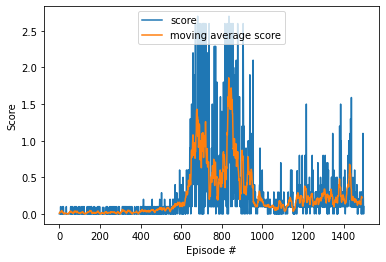

In [8]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

avg_score = moving_average(scores)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='score')
plt.plot(np.arange(len(avg_score)), avg_score, label='moving average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.legend(loc='upper center')
plt.show()

The MADDPG implementation reaches an average return (overall 100 episodes) of `+0.61` after `700` episode of training and reaches `+0.89` after `900` episode. The environment is solved around episode of `650`. The learning exhibits a lot of oscillations due to the non-stationary nature of the multi-agent environment.

The evaluation of the agents' best policies seem to be strong as shown below.

In [9]:
# evaluation
maddpg_agents.load_checkpoint()
num_eval = 5
for i_eval in range(num_eval):
    cum_rewards = np.zeros(num_agents)
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    print(f'\nEvaluation {i_eval}:')
    while True:
        actions=maddpg_agents.act(states, 0.)
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        cum_rewards += rewards
        print('\rTotal rewards for agent 0: {:.2f}; agent 1:{:.2f} '.format(cum_rewards[0], cum_rewards[1]), end="")
        if np.any(dones):
            break


Evaluation 0:
Total rewards for agent 0: 2.60; agent 1:2.60 
Evaluation 1:
Total rewards for agent 0: 2.60; agent 1:2.60 
Evaluation 2:
Total rewards for agent 0: 2.60; agent 1:2.70 
Evaluation 3:
Total rewards for agent 0: 2.60; agent 1:2.60 
Evaluation 4:
Total rewards for agent 0: 2.70; agent 1:2.60 

In [10]:
env.close()

### Conclusions

MADDPG is able to solve this relatively simple cooperative multi-agent environment through the centralized training, local execution approach. Although the learning does exhibit a lot of oscillations due to the non-stationary nature of the environment needed for learning to converge.

There are a number of potential future improvements:  
1. Systematic fine-tuning of hyper-parameters, e.g. varying learning rates depending on performance, varying policy noise etc.
2. Implement ensemble learning discussed in the [original MADDPG paper](https://arxiv.org/pdf/1706.02275v4.pdf)
3. Explore allowing communication among agents such as in [this paper](https://openreview.net/pdf?id=HylSk205YQ)
4. Explore combining time series model - recurrent neural network to improve robustness of learning under constantly changing environment such as in [this paper](https://openreview.net/pdf?id=Ske_NJK2s4)